In [1]:
import abm_utils.familiarity as fam
import h3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon
import geopandas as gpd

In [ ]:
fam_data = pd.read_csv("C:/Users/freud/Tensorflow/DataFrames/all_waybill_info_meituan_0322.csv")

min_lat = 0
min_lon = 0
max_lat = 46000000
max_lon = 174700000

"first we will filter the data and remvoing a order area encupsuled from the main area of operation"

fam_data = fam_data[
        (fam_data['recipient_lat'] >= min_lat) &
        (fam_data['recipient_lat'] <= max_lat) &
        (fam_data['recipient_lng'] >= min_lon) &
        (fam_data['recipient_lng'] <= max_lon) &
        (fam_data['sender_lat'] >= min_lat) &
        (fam_data['sender_lat'] <= max_lat) &
        (fam_data['sender_lng'] >= min_lon) &
        (fam_data['sender_lng'] <= max_lon)] 

fam_data = fam_data[fam_data['is_courier_grabbed'] != 0].reset_index(drop=True) #data cleaning

fam_data['platform_order_date'] = fam_data['platform_order_time']
fam_data['platform_order_date'] = pd.to_datetime(fam_data['platform_order_date'], unit='s') + pd.Timedelta(hours=8) #Offset of 8 hours, because it is probably a chinese timezone

"For the H3 library, we need standard decimal degrees"

scaling_factor = 1_000_000
fam_data['sender_lat'] = fam_data['sender_lat'] / scaling_factor
fam_data['sender_lng'] = fam_data['sender_lng'] / scaling_factor
fam_data['recipient_lat'] = fam_data['recipient_lat'] / scaling_factor
fam_data['recipient_lng'] = fam_data['recipient_lng'] / scaling_factor
fam_data["grab_lat"] = fam_data["grab_lat"] / scaling_factor
fam_data["grab_lng"] = fam_data["grab_lng"] / scaling_factor



In [ ]:
Res = 13  # All courier positions and specific locations (restaurants, customers) are mapped to this grid.
try:
    fam_data['sender_h3'] = fam_data.apply(
        lambda row: h3.latlng_to_cell(row['sender_lat'], row['sender_lng'], Res),
        axis=1
    )
    fam_data['recipient_h3'] = fam_data.apply(
        lambda row: h3.latlng_to_cell(row['recipient_lat'], row['recipient_lng'], Res),
        axis=1
    )
    fam_data['grab_h3'] = fam_data.apply(
        lambda row: h3.latlng_to_cell(row['grab_lat'], row['grab_lng'], Res),
        axis=1
    )
    print("Conversion to H3 indices complete.")


except h3.H3ValueError as e:
    print("ERROR: A coordinate in the dataset is invalid. H3 message: {e}")

Conversion to H3 indices complete.


In [ ]:
fam_data.head()

,Unnamed: 0,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,...,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,platform_order_date,sender_h3,recipient_h3,grab_h3
0,1,20221017,1,1,1,1,1,1,1665937864,0,...,1665936737,1665937344,1665937798,1665936845,1665936006,1665935995,2022-10-16 23:59:55,8d329b58826397f,8d329b589d71c3f,8d329b588263c7f
1,2,20221017,2,2,2,2,1,0,1665939504,0,...,1665937501,1665938346,1665939384,1665938007,1665937107,1665937097,2022-10-17 00:18:17,8d329b5aba8bdbf,8d329b588972a3f,8d329b5ab4ccb7f
2,3,20221017,3,3,3,0,1,0,1665939432,0,...,1665937397,1665937830,1665939822,1665937634,1665937369,1665937028,2022-10-17 00:17:08,8d329b5aa2c82bf,8d329b58171a33f,8d329b5aa2c85bf
3,4,20221017,4,4,4,0,1,0,1665938894,0,...,1665937413,1665937710,1665938262,1665937694,1665937373,1665937092,2022-10-17 00:18:12,8d329b5aa2c82bf,8d329b5ab3988ff,8d329b5ab515b3f
4,5,20221017,5,5,5,3,1,0,1665940500,0,...,1665938741,1665940061,1665940496,1665939225,1665938403,1665938399,2022-10-17 00:39:59,8d329b58bc0cc3f,8d329b58b1460bf,8d329b5894849bf


In [ ]:
active_couriers = fam_data['courier_id'].value_counts()
candidates = active_couriers[active_couriers > 10].index.tolist()
selected_ids = random.sample(candidates, 5)

In [6]:
courier_data = {}

In [ ]:
for c_id in selected_ids:
    c_df = fam_data[fam_data['courier_id'] == c_id].copy()
    history_points = []
    
    for _, row in c_df.iterrows():
        if pd.notna(row.get('grab_h3')):
            history_points.append(row['grab_h3'])
            
        if 'is_courier_grabbed' in row and row['is_courier_grabbed'] != 0:
            if pd.notna(row.get('sender_h3')): history_points.append(row['sender_h3'])
            if pd.notna(row.get('recipient_h3')): history_points.append(row['recipient_h3'])

    calculated_zone = fam.determine_familiarity_zone(history_points, parent_res=8)
    
    courier_data[c_id] = {
        'points': history_points,
        'zone': calculated_zone
    }

In [9]:
def get_hex_polygon(h3_index):
    try:
        boundary = h3.cell_to_boundary(h3_index)
        return Polygon([(p[1], p[0]) for p in boundary])
    except:
        return None

In [ ]:
counts = fam_data['courier_id'].value_counts()
candidates = counts[counts > 20].index.tolist()
selected_ids = random.sample(candidates, 5)

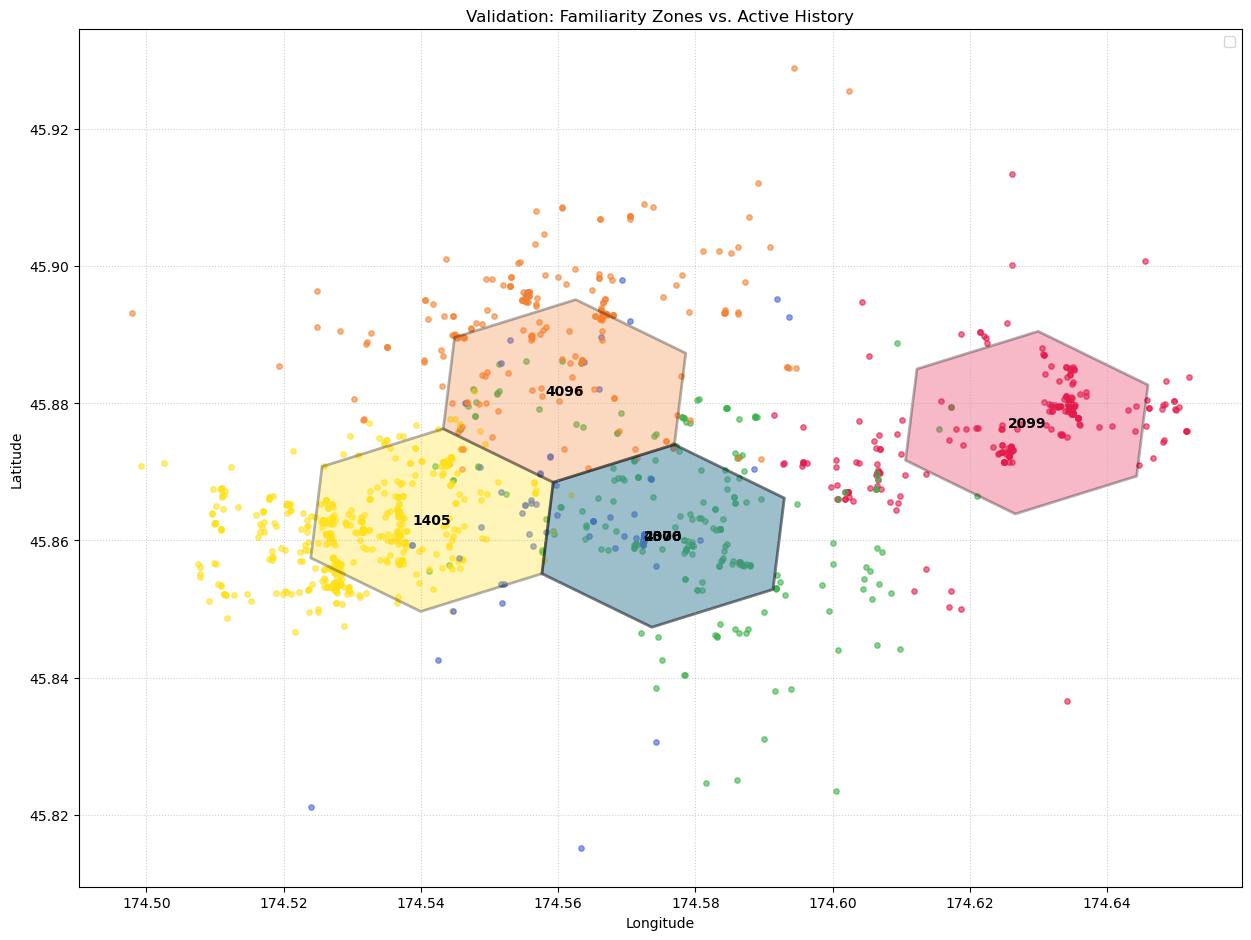

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

zone_geoms = []
zone_colors = []
zone_labels = []

for i, c_id in enumerate(selected_ids):
    color = colors[i % len(colors)]
    
    c_df = fam_data[fam_data['courier_id'] == c_id]
    history_h3 = []
    
    for _, row in c_df.iterrows():
        if isinstance(row.get('grab_h3'), str): 
            history_h3.append(row['grab_h3'])
        if isinstance(row.get('sender_h3'), str):
            history_h3.append(row['sender_h3'])
        if isinstance(row.get('recipient_h3'), str):
            history_h3.append(row['recipient_h3'])
            
    zone_h3 = fam.determine_familiarity_zone(history_h3, parent_res=7)
    
    if zone_h3:
        poly = get_hex_polygon(zone_h3)
        if poly:
            zone_geoms.append(poly)
            zone_colors.append(color)
            zone_labels.append(f"Zone C-{c_id}")
            centroid = poly.centroid
            ax.text(centroid.x, centroid.y, str(c_id), fontsize=10, ha='center', va='center', fontweight='bold')

    lats, lons = [], []
    for h in history_h3:
        try:
            lat, lon = h3.cell_to_latlng(h) #need of lat and lng again
            lats.append(lat)
            lons.append(lon)
        except: continue
        
    ax.scatter(lons, lats, c=color, s=15, alpha=0.6)

if zone_geoms:
    gdf_zones = gpd.GeoDataFrame({'geometry': zone_geoms, 'color': zone_colors})
    gdf_zones.plot(ax=ax, color=gdf_zones['color'], alpha=0.3, edgecolor='black', linewidth=2, zorder=1)

ax.set_title("Validation: Familiarity Zones vs. Active History")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle=':', alpha=0.6)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.show()

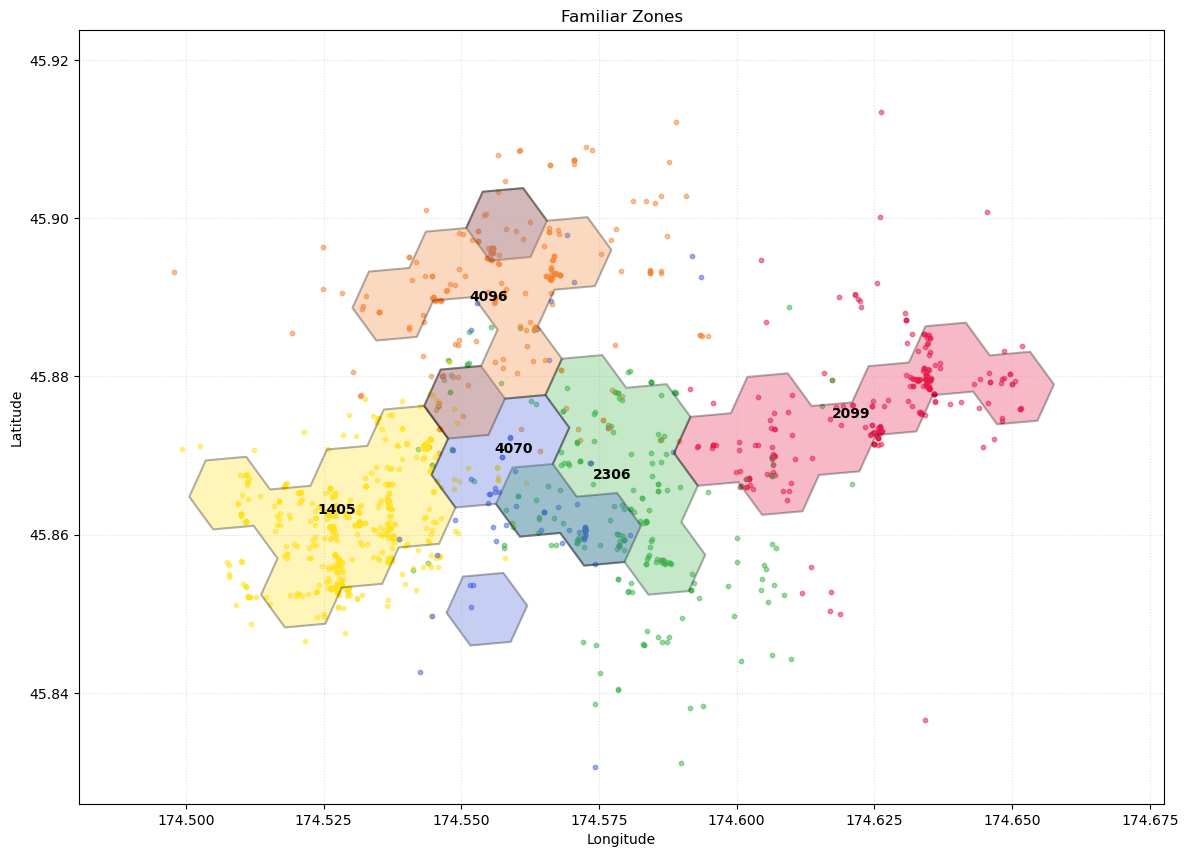

In [ ]:
from shapely.ops import unary_union

fig, ax = plt.subplots(figsize=(14, 14))
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

all_zones_data = []

for i, c_id in enumerate(selected_ids):
    color = colors[i % len(colors)]
    c_df = fam_data[fam_data['courier_id'] == c_id]
    
    history_h3 = []
    # Alle relevanten Spalten sammeln
    for col in ['grab_h3', 'sender_h3', 'recipient_h3']:
        if col in c_df.columns:
            history_h3.extend(c_df[col].dropna().tolist())
            
    zone_set_res8 = fam.get_adaptive_familiar_zone(history_h3, threshold_ratio=0.8)
    #return is a set of hexagons
    
    if not zone_set_res8:
        continue
        
    polys = []
    for h_res8 in zone_set_res8:
        p = get_hex_polygon(h_res8)
        if p: polys.append(p)
        
    #Dissolve removes Hexagon lines, if one hexagon in smaller res
    if polys:
        merged_poly = unary_union(polys)
        all_zones_data.append({
            'courier_id': c_id,
            'geometry': merged_poly,
            'color': color
        })
        
        centroid = merged_poly.centroid
        ax.text(centroid.x, centroid.y, str(c_id), fontsize=10, ha='center', fontweight='bold', color='black')

    plot_lats, plot_lons = [], []
    for h in history_h3:
        h = str(h).strip()
        if h3.is_valid_cell(h):
            lat, lon = fam.get_lat_lon(h)
            if lat:
                plot_lats.append(lat)
                plot_lons.append(lon)
                
    ax.scatter(plot_lons, plot_lats, c=color, s=10, alpha=0.5)

if all_zones_data:
    gdf = gpd.GeoDataFrame(all_zones_data, crs="EPSG:4326")
    
    gdf.plot(ax=ax, color=gdf['color'], alpha=0.3, edgecolor='black', linewidth=1.5)
    minx, miny, maxx, maxy = gdf.total_bounds
    pad = 0.02
    ax.set_xlim(minx - pad, maxx + pad)
    ax.set_ylim(miny - pad, maxy + pad)

ax.set_title("Familiar Zones")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.4, linestyle=':')

plt.show()